<a href="https://colab.research.google.com/github/mzohaibnasir/GenAI/blob/main/09_EndtoEndMedicalChatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Medical Chatbot


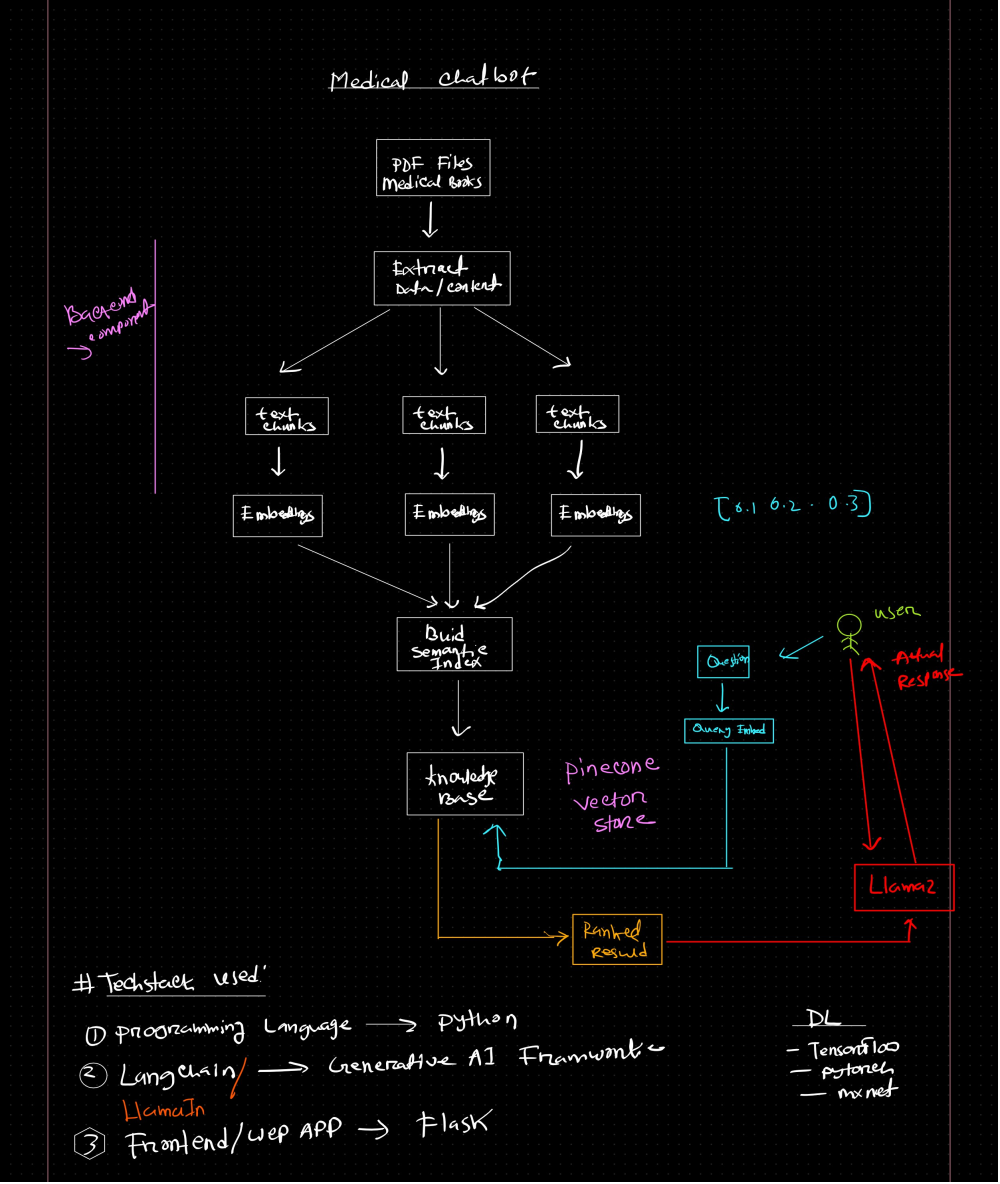


* will be based on out custom data. (PDF files)corpus would be a book





## Process:

### Backend Component
*** [ Data ingestion ] ***  --->  *** [ extract data/content ] ***  --->  *** [ split into text chunks(multiple chunks to facilitate input context window. context window token limit: 4096 )] ***  --->  *** [embeddings of chunks] ***  --->  *** [build semantic index based on all embeddings in vector db (chunk overlap would be beneficial here. Due to this chunk overlap, model would be able to create a relation between different chunks) ] ***  --->  *** [ building Knowledge base using pinecone vector store ]





### User component
*** [ User asks Qs ] ***  --->  *** [ convert Q to query embedding ] ***  --->  *** [ send Query embedding to knowledge base because knowledge base has all of data ] ***  --->  *** [ Knowledge base will give rank results(closest vector to your query)] ***  --->  *** [ send those rank results to Llama2] ***  --->  *** [ send back to User ] ***










-------------------------------------------------------------- ---
**RAG is used to fix hellucinationsiu. RAG is base don our own populated vector database.it also gives context based on metadata we input through input docs.**
**In vector db indexes are being updated instantaneously**
**In vector db, neighbors are semantically close**

In vector db, we have two concepts:

### knowledge base
### semantic index
will build clusters based on semantic index(king and queen will be in single cluster based on distance between vectors


-------------------------------------------------
### chunk overlap : is to get some context from previous text.
Chunk overlap is used in LLM (Large Language Models) to address the issue of context windows. LLMs process input text in fixed-size chunks, but sometimes, the context required to understand the text exceeds the chunk size. By using chunk overlap, the model can consider the surrounding context, even if it's in a different chunk.
Here's how it works:
The input text is divided into overlapping chunks, typically with a overlap of 50-100 tokens.
Each chunk is processed separately, but the model has access to the context from the previous chunk (due to the overlap).
This allows the model to capture long-range dependencies and relationships between different parts of the input text.
Chunk overlap helps LLMs to:
Improve context awareness
Enhance understanding of complex texts
Reduce the impact of chunk boundaries on model performance
It's a technique to help LLMs better understand the input text and generate more accurate and coherent responses.

##Import libraries

In [ ]:
! pip install ctransformers==0.2.5 # to load quantize model with langchain
! pip install sentence-transformers==2.2.2 # for embedding model
! pip install pinecone-client
! pip install langchain==0.1.2
! pip install pymupdf
! pip install langchain_pinecone

In [2]:
from langchain import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Pinecone
# import Pinecone
from langchain.document_loaders import PyMuPDFLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain.prompts import PromptTemplate
from langchain.llms import CTransformers

## create pinecone cluster(index)

In [3]:

from google.colab import userdata
import os
PINECONE_API_KEY = userdata.get("PINECONE_API_KEY")


os.environ['PINECONE_API_KEY'] = PINECONE_API_KEY

## load data from pdf

In [ ]:
def load_pdf(data):
  loader = DirectoryLoader(
      data,
      glob="*.pdf",
      loader_cls=PyMuPDFLoader

  )

  docs = loader.load()
  return docs

extracted_data = load_pdf("/content/data/")
extracted_data

## create text chunks

In [5]:
def text_split(extracted_data):
  text_spliter = RecursiveCharacterTextSplitter(
      chunk_size = 500,
      chunk_overlap= 20
  )
  text_chunks = text_spliter.split_documents(extracted_data)


  return text_chunks


text_chunks = text_split(extracted_data)
len(text_chunks)

5779

# LLM download


In [ ]:
from huggingface_hub import hf_hub_download

model_name_or_path = "TheBloke/Llama-2-7B-Chat-GGML"
model_basename = "llama-2-7b-chat.ggmlv3.q4_0.bin"



model_path = hf_hub_download(
    repo_id = model_name_or_path,
    filename = model_basename
)
model_path

## Download embedding model

In [7]:
def download_hf_embedding_model():
  embeddings = HuggingFaceEmbeddings(
      model_name="sentence-transformers/all-MiniLM-L6-v2"
  )
  return embeddings

embeddings = download_hf_embedding_model()
embeddings

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [8]:
len(embeddings.embed_query("Hello World"))

384

## pinecone

In [9]:
index_name = 'testing'


In [10]:
# initialize
from langchain_pinecone import PineconeVectorStore




# vectorstore_from_docs = PineconeVectorStore.from_texts(
#         [t.page_content for t in  text_chunks],
#         index_name=index_name,
#         embedding=embeddings,
#     )


# vectorstore_from_docs

In [11]:
# if you already have an oindex you can load it like this
docsearch = PineconeVectorStore.from_existing_index(index_name, embeddings)

query = "what is polen allergy?"

docs = docsearch.similarity_search(query, k=3)
docs

[Document(page_content='polposis, urticaria. Examples include zafirlukast (Acco-\nlate),montelukast (Singulair), and zileuton (Zyflo).\nWhen zileuton is used, care must be taken to measure\nliver enzymes.\nImmunotherapy\nIn this form of therapy, allergen is injected into the\nskin in increasing doses over a specific period of time.\nThis may be helpful for patients who do not respond to\nmedications or avoidance of allergens in the environ-\nment. This type of therapy may reduce the need for med-\nications.'),
 Document(page_content='by eveidence of allergic responses in the patient’s clini-\ncal history.\nSkin tests\nSkin tests are performed by administering a tiny\ndose of the suspected allergen by pricking, scratching,\npuncturing or injecting the skin. The allergen is applied\nto the skin as an auqeous extract, usually on the back,\nforearms, or top of the thighs. Once in the skin, the aller-\ngen may produce a classic immune wheal and flare\nresponse (a skin lesion with a raise, w

## Inegrating LLM

In [12]:
prompt_template="""
Use the following pieces of information to answer the user's question.
If you don't know the answer, just say you dont know, dont try to make up an answer,

Context: {context}
Question: {question}

Only return the helpful answe below and nothing else.
Helpful answer:

"""

In [13]:
PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables= ['context', 'question']

)

chain_type_kwargs = {'prompt':PROMPT}

In [14]:
llm = CTransformers(
    model=model_path,
    model_type="llama",
    config={
        'max_new_tokens':512,
        'temperature':0.8
    }

)
llm

CTransformers(client=<ctransformers.llm.LLM object at 0x7a17b099fc70>, model='/root/.cache/huggingface/hub/models--TheBloke--Llama-2-7B-Chat-GGML/snapshots/76cd63c351ae389e1d4b91cab2cf470aab11864b/llama-2-7b-chat.ggmlv3.q4_0.bin', model_type='llama', config={'max_new_tokens': 512, 'temperature': 0.8})

# RETRIEVALqa

In [15]:
from langchain.chains import RetrievalQA

qa = RetrievalQA.from_chain_type(
    llm = llm,
    chain_type="stuff",
    retriever = docsearch.as_retriever(
        search_kwargs={
            'k':2
        }
    ),
    return_source_documents=True,
    chain_type_kwargs=chain_type_kwargs
)

qa

RetrievalQA(combine_documents_chain=StuffDocumentsChain(llm_chain=LLMChain(prompt=PromptTemplate(input_variables=['context', 'question'], template="\nUse the following pieces of information to answer the user's question.\nIf you don't know the answer, just say you dont know, dont try to make up an answer,\n\nContext: {context}\nQuestion: {question}\n\nOnly return the helpful answe below and nothing else.\nHelpful answer:\n\n"), llm=CTransformers(client=<ctransformers.llm.LLM object at 0x7a17b099fc70>, model='/root/.cache/huggingface/hub/models--TheBloke--Llama-2-7B-Chat-GGML/snapshots/76cd63c351ae389e1d4b91cab2cf470aab11864b/llama-2-7b-chat.ggmlv3.q4_0.bin', model_type='llama', config={'max_new_tokens': 512, 'temperature': 0.8})), document_variable_name='context'), return_source_documents=True, retriever=VectorStoreRetriever(tags=['PineconeVectorStore', 'HuggingFaceEmbeddings'], vectorstore=<langchain_pinecone.vectorstores.PineconeVectorStore object at 0x7a17b0b145e0>, search_kwargs={'

In [ ]:
while True:
  user_input=input(f"Input Prompt:")
  result=qa.invoke({
      'query':user_input
  })
  print("Response: ", result["result"])

Input Prompt:what is polen allergy?
